In [25]:
# !conda uninstall -y --force pillow pil jpeg libtiff libjpeg-turbo >&NULL
# !pip   uninstall -y         pillow pil jpeg libtiff libjpeg-turbo >&NULL
# !conda install -yc conda-forge libjpeg-turbo >&NULL
# !CFLAGS="${CFLAGS} -mavx2" pip install --upgrade --no-cache-dir --force-reinstall --no-binary :all: --compile pillow-simd >&NULL
# !conda install -y jpeg libtiff >&NULL
# !python -c "import PIL; print(PIL.__version__)"

9.0.0.post1


In [1]:
# !python -c "from PIL import features; print(features.check_feature('libjpeg_turbo'))"

True


In [2]:
from fastai.vision.all import *
np.random.seed(5435)

In [2]:
!kaggle datasets download -d nikitarom/planets-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!cp "kaggle.json" "/root/.kaggle/kaggle.json"

In [4]:
!kaggle datasets download -d nikitarom/planets-dataset

 98% 1.47G/1.50G [00:41<00:00, 36.5MB/s]
100% 1.50G/1.50G [00:41<00:00, 39.0MB/s]


In [5]:
!unzip planets-dataset.zip >&NULL
!rm NULL

In [3]:
import pandas as pd
import os

base_dir="./planet/planet/"
os.listdir(base_dir)
# pd.read_csv("/content/train_v2.csv/train_v2.csv")

['sample_submission.csv', 'train_classes.csv', 'test-jpg', 'train-jpg']

In [4]:
train_df=pd.read_csv(base_dir+"train_classes.csv")
train_df['image_name']=base_dir+"train-jpg/"+train_df['image_name']+".jpg"
train_df

,image_name,tags
0,./planet/planet/train-jpg/train_0.jpg,haze primary
1,./planet/planet/train-jpg/train_1.jpg,agriculture clear primary water
2,./planet/planet/train-jpg/train_2.jpg,clear primary
3,./planet/planet/train-jpg/train_3.jpg,clear primary
4,./planet/planet/train-jpg/train_4.jpg,agriculture clear habitation primary road
...,...,...
40474,./planet/planet/train-jpg/train_40474.jpg,clear primary
40475,./planet/planet/train-jpg/train_40475.jpg,cloudy
40476,./planet/planet/train-jpg/train_40476.jpg,agriculture clear primary
40477,./planet/planet/train-jpg/train_40477.jpg,agriculture clear primary road


In [5]:
(train_df.isnull()).sum()

image_name    0
tags          0
dtype: int64

In [6]:
train_data=np.array(train_df)
train_data.shape

(40479, 2)

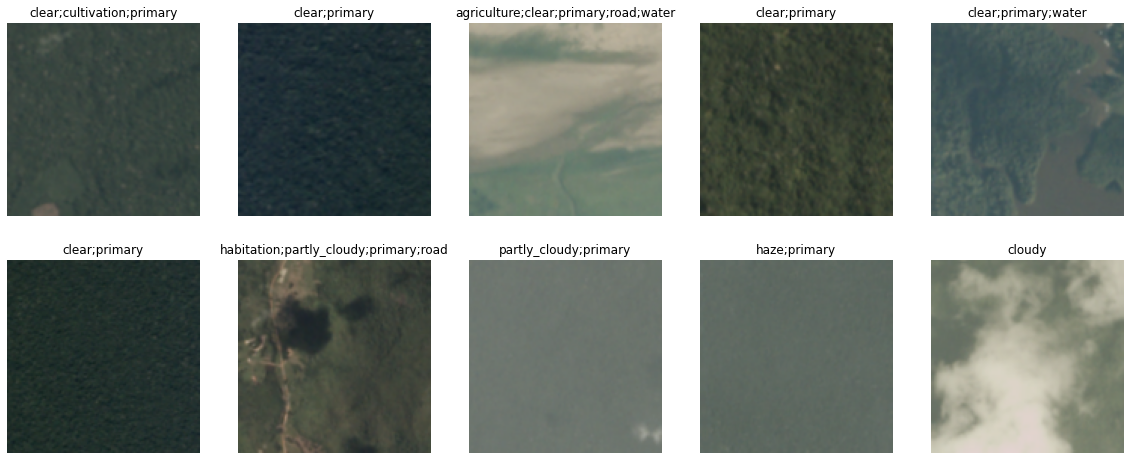

In [7]:
def get_dls(size,bs):
  dblock=DataBlock(blocks=[ImageBlock,MultiCategoryBlock],
                    item_tfms=Resize(size),
                    # batch_tfms=[*aug_transforms(mult=1,flip_vert=True,max_rotate=90,max_warp=0),Normalize.from_stats(*imagenet_stats)],
                    batch_tfms=[*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),Normalize.from_stats(*imagenet_stats)],
                    get_x=lambda x:x[0],
                    get_y=lambda x:x[1].split(' '),
                    splitter=RandomSplitter(0.2,341)
  )
  # ds=dblock.datasets(train_data)
  # ds[0]
  return dblock.dataloaders(train_data,shuffle=True,bs=bs)
dls=get_dls(128,128)
dls.train.show_batch(max_n=10,ncols=5,figsize=(4*5,4*2))

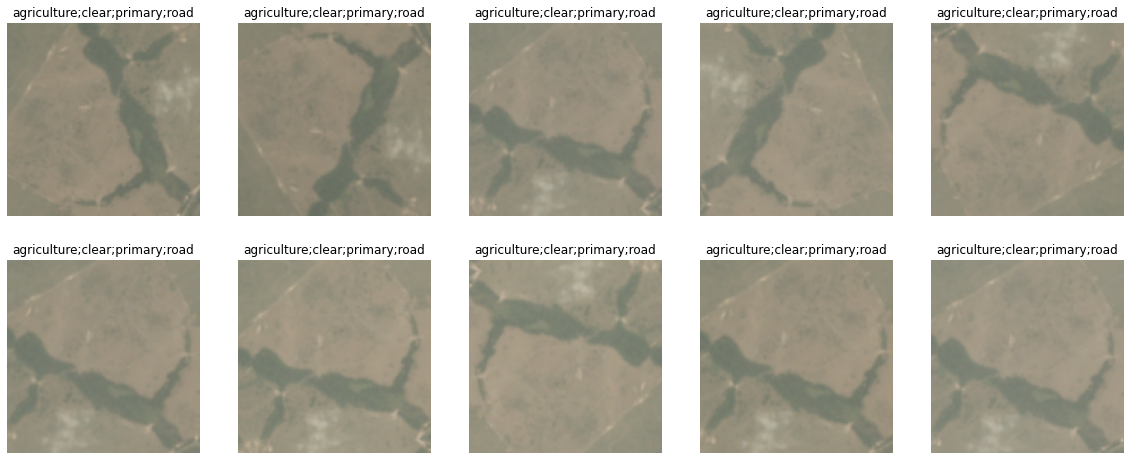

In [8]:
dls.train.show_batch(max_n=10,ncols=5,figsize=(4*5,4*2),unique=True)

In [9]:
acc_02 = partial(accuracy_multi, thresh=0.2)  # function
f_score = FBetaMulti(beta=2,average='samples',thresh=0.2)            # class
# learn = vision_learner(dls,models.resnet50,metrics=[acc_02,f_score])
learn = vision_learner(dls,models.resnet50,metrics=[acc_02,f_score])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# learn.lr_find()

In [11]:
# lr=1e-1
# for i in range(5):
#   learn.fit_one_cycle(i+1,lr_max=slice(lr))
#   lr/=5

In [12]:
# learn.recorder.plot_loss()

In [13]:
# learn.fit_one_cycle(2,lr_max=slice(1e-2))

In [14]:
lr=1e-2
learn.fit_one_cycle(5,lr_max=slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.160781,0.116291,0.946147,0.900309,02:11
1,0.116625,0.100337,0.944991,0.911050,02:08
2,0.104128,0.094058,0.952265,0.917892,02:09
3,0.096059,0.088726,0.954576,0.922019,02:07
4,0.093255,0.087598,0.953130,0.922946,02:07


In [15]:
learn.save("stage_1")

Path('models/stage_1.pth')

In [16]:
learn.unfreeze()
# learn.lr_find()

In [17]:
learn.fit_one_cycle(5,lr_max=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.095577,0.089763,0.953712,0.920417,02:26
1,0.093713,0.087127,0.956175,0.923200,02:26
2,0.087429,0.085710,0.955303,0.923150,02:25
3,0.079578,0.083256,0.958210,0.927410,02:25
4,0.075137,0.082702,0.958152,0.928185,02:25


In [18]:
learn.save('stage_2')

Path('models/stage_2.pth')

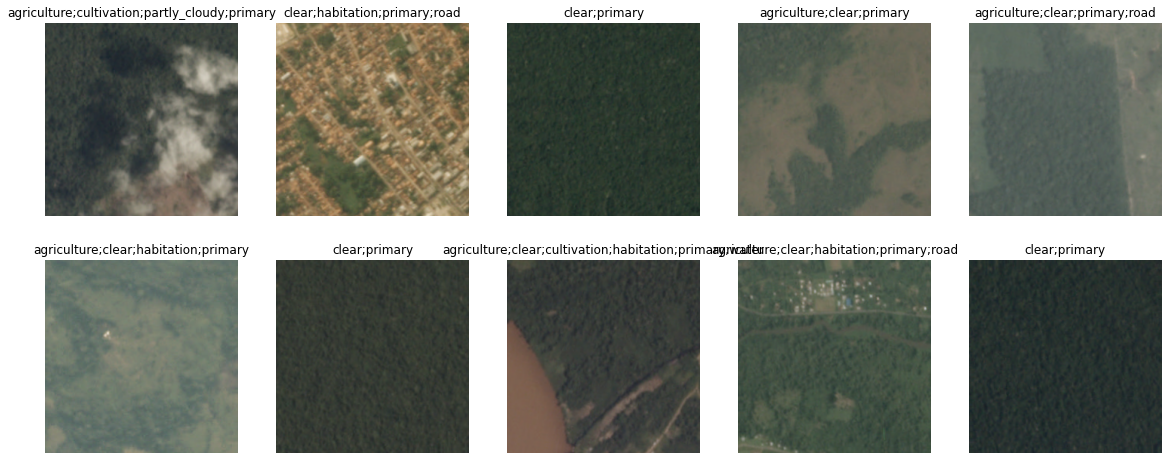

In [19]:
dls=get_dls(256,64)
dls.train.show_batch(max_n=10,ncols=5,figsize=(4*5,4*2))

In [20]:
learn = vision_learner(dls,models.resnet50,metrics=[acc_02,f_score])
learn.load("stage_2")
learn.freeze()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# learn.lr_find()

In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(5,lr_max=slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.088735,0.084570,0.956989,0.927081,05:51
1,0.086420,0.082391,0.958943,0.928645,05:51
2,0.086172,0.081460,0.958718,0.929824,05:53
3,0.083349,0.080867,0.958050,0.930079,05:52
4,0.078994,0.080995,0.957810,0.929420,05:51


In [24]:
learn.save('stage_1_256')

Path('models/stage_1_256.pth')

SuggestedLRs(valley=2.0892961401841603e-05)

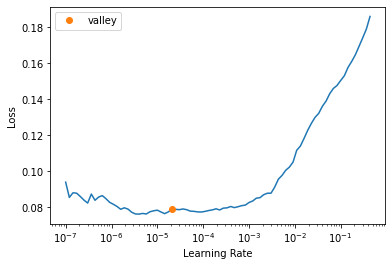

In [25]:
learn.unfreeze()
learn.lr_find()

In [26]:
learn.fit_one_cycle(5,lr_max=slice(1e-6,lr/5))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.081073,0.081128,0.958311,0.930022,07:47
1,0.080734,0.079950,0.958667,0.929832,07:59
2,0.080066,0.080320,0.958166,0.929341,07:48
3,0.077265,0.079831,0.960077,0.931670,07:47
4,0.077789,0.079785,0.960368,0.931381,07:47


In [27]:
learn.save('stage_2_256')

Path('models/stage_2_256.pth')

Getting Results

In [99]:
from glob import glob

test_list=glob(base_dir+'test-jpg/*')+glob('test-jpg-additional/test-jpg-additional/*')
# test_list=glob('test-jpg-additional/test-jpg-additional/*')
# test_list
len(test_list)

61191

In [100]:
test_dl=dls.test_dl(test_list)

In [101]:
test_dl.one_batch()[0].shape

torch.Size([64, 3, 256, 256])

In [102]:
class_names=dls.vocab
class_names

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

In [103]:
thresh=0.2
test_preds=learn.get_preds(dl=test_dl)[0]
test_preds=(test_preds>thresh)*1.
test_preds=[" ".join([class_names[i] for i,p in enumerate(pred) if p==1]) for pred in test_preds]

In [104]:
test_preds[:4]

['cloudy haze primary',
 'clear primary',
 'clear primary water',
 'clear primary']

In [109]:
fnames = [f.rsplit("/",1)[1].rsplit('.',1)[0] for f in test_list]
fnames[:4]

['test_37185', 'test_17250', 'test_9084', 'test_22620']

In [110]:
if os.path.exists("submission.csv"): os.remove('submission.csv')
df=pd.DataFrame({"image_name":fnames,"tags":test_preds})
df.to_csv("submission.csv",mode='a',header=True,index=False)

In [111]:
pd.read_csv("submission.csv").head()

,image_name,tags
0,test_37185,cloudy haze primary
1,test_17250,clear primary
2,test_9084,clear primary water
3,test_22620,clear primary
4,test_9556,agriculture bare_ground clear primary road


In [112]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission.csv -m "Message"

100% 2.19M/2.19M [00:04<00:00, 546kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space